# Demo 2: Normalization of source estimator

As suggested by Mat, here is a demonstration of building the normalization of source estimator as described in https://arxiv.org/abs/1310.7547

In [1]:
using Symlens

Weight function for $i=j$, 

$$\begin{aligned}
W_{\ell_{1} \ell_{2} L}^{S^2}= &\sqrt{\frac{\left(2 \ell_{1}+1\right)\left(2 \ell_{2}+1\right)(2 L+1)}{4 \pi}} \\
& \times\left(\begin{array}{ccc}
\ell_{1} & \ell_{2} & L \\
0 & 0 & 0
\end{array}\right) \mathcal{Y}_{\ell_{1}} \mathcal{Y}_{\ell_{2}}
\end{aligned}
$$

Next we will represent this expression using `Symlens` built-in quantities. The only new one that we need to define is $\mathcal{Y}$

In [2]:
@syms y(ℓ)

W = ((2ℓ+1)*(2ℓ₁+1)*(2ℓ₂+1)/4π)^(1/2)*w3j(ℓ₁,ℓ₂,ℓ,0,0,0)*y(ℓ₁)*y(ℓ₂)

0.28209479177387814((1 + 2ℓ)^0.5)*((1 + 2ℓ₁)^0.5)*((1 + 2ℓ₂)^0.5)*w3j(ℓ₁, ℓ₂, ℓ, 0, 0, 0)*y(ℓ₁)*y(ℓ₂)

Note that sqrt should be represented with exponent, as opposed to `sqrt` which is currently not recognized by `Symlens` (to be implemented). Normalization expression we are interested in is given by

$$ 
R_L^{S^2 S^2} = \frac{1}{2(2L+1)}\sum_{\ell_1\ell_2} W_{\ell_1\ell_2\ell}^{S^2} W_{\ell_1\ell_2\ell}^{S^2} F_{\ell_1}F_{\ell_2}
$$

Represent it in symbolic form

In [3]:
@syms F(ℓ)

R = (W^2*F(ℓ₁)*F(ℓ₂))/(2*(2ℓ+1))

(0.07957747154594766(1 + 2ℓ)*(1 + 2ℓ₁)*(1 + 2ℓ₂)*(w3j(ℓ₁, ℓ₂, ℓ, 0, 0, 0)^2)*(y(ℓ₁)^2)*(y(ℓ₂)^2)*F(ℓ₁)*F(ℓ₂)) / (2 + 4ℓ)

We want to build a calculator that performs the $\ell_1$ and $\ell_2$ sum

In [4]:
@syms Fl yl

Symlens.build_l12sum_calculator(R, "source_est",
    Dict(F(ℓ)=>Fl, y(ℓ)=>yl),
    [Fl, yl],
    evaluate=false
)

:(function source_est(lmax, rlmin, rlmax, Fl, yl)
      npoints = ((max(lmax, length.([Fl, yl])...) * 3 + 1) / 2 |> round) |> Int
      glq = wignerd.glquad(npoints)
      ℓ = collect(rlmin:rlmax)
      zeta_1 = zeros(rlmax + 1)
      let Fl = view(Fl, rlmin + 1:rlmax + 1), yl = view(yl, rlmin + 1:rlmax + 1)
          zeta_1[rlmin + 1:rlmax + 1] .= @__dot__(Fl*(yl^2))
      end
      zeta_1 = cf_from_cl(glq, 0, 0, zeta_1; prefactor = true)
      ℓ = collect(0:lmax)
      res = cl_from_cf(glq, 0, 0, lmax, @__dot__(6.283185307179585(zeta_1^2))) |> (x->begin
                      x .*= @__dot__(0.5)
                      x
                  end)
      res
  end)

Here we will mention something new. Since the expression of interests is a normalization. We are interested in its reciprocol as opposed to itself. To support that, the `build_l12sum_calculator` function has an option called `post` which allows you to pass in a list of expressions to append to the end before returning the final result. Here, instead of `res`, we are interested in `res.^-1`. To add that we can do the following

In [5]:
Symlens.build_l12sum_calculator(R, "source_est",
    Dict(F(ℓ)=>Fl, y(ℓ)=>yl),
    [Fl, yl],
    post=[:(res .^= -1)],
    evaluate=false
)

:(function source_est(lmax, rlmin, rlmax, Fl, yl)
      npoints = ((max(lmax, length.([Fl, yl])...) * 3 + 1) / 2 |> round) |> Int
      glq = wignerd.glquad(npoints)
      ℓ = collect(rlmin:rlmax)
      zeta_1 = zeros(rlmax + 1)
      let Fl = view(Fl, rlmin + 1:rlmax + 1), yl = view(yl, rlmin + 1:rlmax + 1)
          zeta_1[rlmin + 1:rlmax + 1] .= @__dot__(Fl*(yl^2))
      end
      zeta_1 = cf_from_cl(glq, 0, 0, zeta_1; prefactor = true)
      ℓ = collect(0:lmax)
      res = cl_from_cf(glq, 0, 0, lmax, @__dot__(6.283185307179585(zeta_1^2))) |> (x->begin
                      x .*= @__dot__(0.5)
                      x
                  end)
      res .^= -1
      res
  end)

First note that an expression is prefixed by `:` in Julia's syntax. Then notice that this expression is inserted right before returnning `res` which achieves what we want. There is a similar option called `pre` which insert expression in the beginning of the function in case any preprocessing is needed. It works similarly so I will not demonstrate here. 

Next we can evaluate the function and test it

In [6]:
Symlens.build_l12sum_calculator(R, "source_est",
    Dict(F(ℓ)=>Fl, y(ℓ)=>yl),
    [Fl, yl],
    post = [:(res .^= -1)],
    evaluate=true
)

source_est (generic function with 1 method)

In [7]:
?Symlens.source_est

No documentation found.

`Symlens.source_est` is a `Function`.

```
# 1 method for generic function "source_est":
[1] source_est(lmax, rlmin, rlmax, Fl, yl) in Symlens at none:1
```


## Comparing results to pytempura

In [8]:
using PyCall, Plots
@pyimport numpy as np
@pyimport pytempura as tp

In [9]:
cls = np.loadtxt("../data/cosmo2017_10K_acc3_lensedCls.dat");

In [10]:
lmax = 3000
l = collect(0:lmax)
nltt = @. 10*(1+l/1000)^(3)  # dummy noise model
cltt = [0,0,cls[1:lmax-1,2]...]
ocltt = nltt + cltt;

### Tempura call

In [11]:
ucl = Dict("TT" => cltt)
tcl = Dict("TT" => ocltt)
res_py = tp.get_norms(["src"], ucl, tcl, 0, 3000,3000)["src"]; 

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/yilun/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


### Symlens call

In [26]:
yl = one.(l)
Fl = 1 ./ ocltt
res_sym = Symlens.source_est(3000, 0, 3000, Fl, yl);

### Comparison

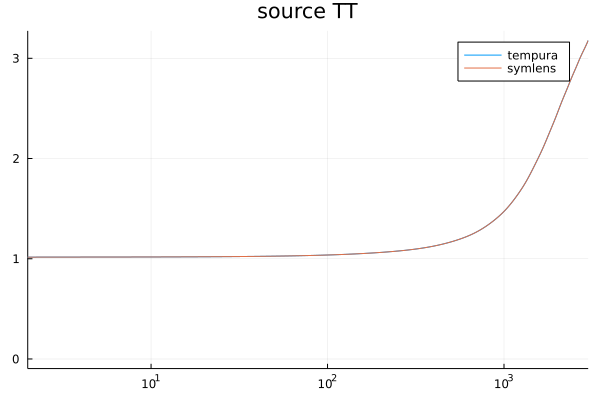

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based xscale
└ @ Plots /home/yilun/.julia/packages/Plots/9C6z9/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based xscale
└ @ Plots /home/yilun/.julia/packages/Plots/9C6z9/src/utils.jl:95


In [15]:
plot(l, [res_py res_sym], labels=["tempura" "symlens"], xaxis=:log10, xlim=(2,3000), title="source TT")

It shows that our quickly built estimator produces the same result as the source estimator implemented in tempura. We can compare their difference.

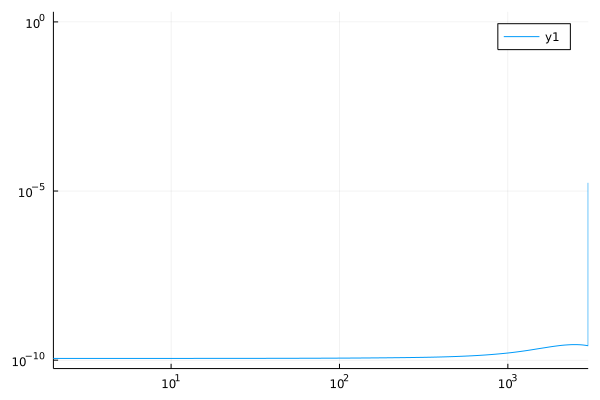

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based xscale
└ @ Plots /home/yilun/.julia/packages/Plots/9C6z9/src/utils.jl:95


In [19]:
plot(l, abs.((res_py .- res_sym)./res_sym), xaxis=:log10, xlim=(2,3000), yaxis=:log10)

They mostly differ by 1e-10 with an exception at the end point when it reaches 1e-5, which may be due to some difference handling of the edge case and might be interesting to investigate. 

### Performance comparison

We can compare the performance of our symbolicly built function with the function in tempura. To do that we will use the powerful `BenchmarkTools.jl` library. 

In [22]:
using BenchmarkTools

In [23]:
@btime tp.get_norms(["src"], $ucl, $tcl, 0, 3000,3000)["src"]; 

  1.021 s (75 allocations: 26.67 KiB)


In [27]:
@btime Symlens.source_est(3000, 0, 3000, $Fl, $yl);

  12.000 ms (9056 allocations: 750.14 KiB)


Notice how fast our function runs. For my test the performance gain is around 100 times faster, but it may differ according to your specs 